# 3D CNN

Basic + Augmentations (invert, rotate, zoom, blur, noise) + Batch Norm + Dropout (0.05)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
# import tensorflow as tf

# RANDOM_SEED = 792379571013149
# tf.random.set_seed(RANDOM_SEED)

# print(tf.version.VERSION)
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

## Setup

In [4]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20201229-175812
Wall time: 4.01 ms


In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
#     'l2_beta': None,
    'dropout': 0.05,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00020,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 200,
    'patience': 25,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0.2, 0.20),
        'shear': (0, 0), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

## Train

In [6]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [7]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201213-182225', 'cp-0002.ckpt')

In [8]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [9]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20201229-175812
checkpoint dir: ../../tmp\checkpoints\20201229-175812
log dir: ../../tmp\logs\20201229-175812
loading ../../tmp\data-v3\train_x.npy, ../../tmp\data-v3\train_y.npy...
loading ../../tmp\data-v3\val_x.npy, ../../tmp\data-v3\val_y.npy...
training...
Epoch 1/200
51/51 [==============================] - ETA: 0s - loss: 2.0320 - recall: 0.4925 - precision: 0.4925 - auc: 0.4920 - categorical_accuracy: 0.4925
Epoch 00001: val_auc improved from -inf to 0.38000, saving model to ../../tmp\checkpoints\20201229-175812\cp-0001.ckpt
51/51 [==============================] - 27s 537ms/step - loss: 2.0320 - recall: 0.4925 - precision: 0.4925 - auc: 0.4920 - categorical_accuracy: 0.4925 - val_loss: 0.9204 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.3800 - val_categorical_accuracy: 0.3800
Epoch 2/200
51/51 [==============================] - ETA: 0s - loss: 0.9053 - recall: 0.4428 - precision: 0.4428 - auc: 0.4185 - categorical_accuracy: 0.4428
Epoch 00002: val_auc d

Epoch 16/200
51/51 [==============================] - ETA: 0s - loss: 0.6423 - recall: 0.6144 - precision: 0.6144 - auc: 0.6837 - categorical_accuracy: 0.6144
Epoch 00016: val_auc improved from 0.47765 to 0.50010, saving model to ../../tmp\checkpoints\20201229-175812\cp-0016.ckpt
51/51 [==============================] - 25s 489ms/step - loss: 0.6423 - recall: 0.6144 - precision: 0.6144 - auc: 0.6837 - categorical_accuracy: 0.6144 - val_loss: 0.6765 - val_recall: 0.4500 - val_precision: 0.4500 - val_auc: 0.5001 - val_categorical_accuracy: 0.4500
Epoch 17/200
51/51 [==============================] - ETA: 0s - loss: 0.6330 - recall: 0.6244 - precision: 0.6244 - auc: 0.6923 - categorical_accuracy: 0.6244
Epoch 00017: val_auc did not improve from 0.50010
51/51 [==============================] - 24s 471ms/step - loss: 0.6330 - recall: 0.6244 - precision: 0.6244 - auc: 0.6923 - categorical_accuracy: 0.6244 - val_loss: 0.6859 - val_recall: 0.4100 - val_precision: 0.4100 - val_auc: 0.4895 - val

51/51 [==============================] - ETA: 0s - loss: 0.5670 - recall: 0.7264 - precision: 0.7264 - auc: 0.8166 - categorical_accuracy: 0.7264
Epoch 00032: val_auc did not improve from 0.67115
51/51 [==============================] - 23s 444ms/step - loss: 0.5670 - recall: 0.7264 - precision: 0.7264 - auc: 0.8166 - categorical_accuracy: 0.7264 - val_loss: 0.6424 - val_recall: 0.5800 - val_precision: 0.5800 - val_auc: 0.6069 - val_categorical_accuracy: 0.5800
Epoch 33/200
51/51 [==============================] - ETA: 0s - loss: 0.5901 - recall: 0.7065 - precision: 0.7065 - auc: 0.7819 - categorical_accuracy: 0.7065
Epoch 00033: val_auc improved from 0.67115 to 0.67860, saving model to ../../tmp\checkpoints\20201229-175812\cp-0033.ckpt
51/51 [==============================] - 23s 454ms/step - loss: 0.5901 - recall: 0.7065 - precision: 0.7065 - auc: 0.7819 - categorical_accuracy: 0.7065 - val_loss: 0.6284 - val_recall: 0.6600 - val_precision: 0.6600 - val_auc: 0.6786 - val_categorical_

51/51 [==============================] - ETA: 0s - loss: 0.5541 - recall: 0.7488 - precision: 0.7488 - auc: 0.8412 - categorical_accuracy: 0.7488
Epoch 00048: val_auc did not improve from 0.75255
51/51 [==============================] - 25s 483ms/step - loss: 0.5541 - recall: 0.7488 - precision: 0.7488 - auc: 0.8412 - categorical_accuracy: 0.7488 - val_loss: 0.6141 - val_recall: 0.6900 - val_precision: 0.6900 - val_auc: 0.7382 - val_categorical_accuracy: 0.6900
Epoch 49/200
51/51 [==============================] - ETA: 0s - loss: 0.5462 - recall: 0.7761 - precision: 0.7761 - auc: 0.8537 - categorical_accuracy: 0.7761
Epoch 00049: val_auc did not improve from 0.75255
51/51 [==============================] - 23s 450ms/step - loss: 0.5462 - recall: 0.7761 - precision: 0.7761 - auc: 0.8537 - categorical_accuracy: 0.7761 - val_loss: 0.6139 - val_recall: 0.7000 - val_precision: 0.7000 - val_auc: 0.7478 - val_categorical_accuracy: 0.7000
Epoch 50/200
51/51 [==============================] - E

Epoch 65/200
51/51 [==============================] - ETA: 0s - loss: 0.5493 - recall: 0.7512 - precision: 0.7512 - auc: 0.8526 - categorical_accuracy: 0.7512
Epoch 00065: val_auc did not improve from 0.75345
51/51 [==============================] - 23s 448ms/step - loss: 0.5493 - recall: 0.7512 - precision: 0.7512 - auc: 0.8526 - categorical_accuracy: 0.7512 - val_loss: 0.6114 - val_recall: 0.7000 - val_precision: 0.7000 - val_auc: 0.7518 - val_categorical_accuracy: 0.7000
Epoch 66/200
51/51 [==============================] - ETA: 0s - loss: 0.5509 - recall: 0.7587 - precision: 0.7587 - auc: 0.8370 - categorical_accuracy: 0.7587
Epoch 00066: val_auc did not improve from 0.75345
51/51 [==============================] - 23s 447ms/step - loss: 0.5509 - recall: 0.7587 - precision: 0.7587 - auc: 0.8370 - categorical_accuracy: 0.7587 - val_loss: 0.6114 - val_recall: 0.7000 - val_precision: 0.7000 - val_auc: 0.7521 - val_categorical_accuracy: 0.7000
Epoch 67/200
51/51 [======================

Epoch 82/200
51/51 [==============================] - ETA: 0s - loss: 0.5506 - recall: 0.7637 - precision: 0.7637 - auc: 0.8378 - categorical_accuracy: 0.7637
Epoch 00082: val_auc improved from 0.75395 to 0.75405, saving model to ../../tmp\checkpoints\20201229-175812\cp-0082.ckpt
51/51 [==============================] - 24s 478ms/step - loss: 0.5506 - recall: 0.7637 - precision: 0.7637 - auc: 0.8378 - categorical_accuracy: 0.7637 - val_loss: 0.6105 - val_recall: 0.7100 - val_precision: 0.7100 - val_auc: 0.7541 - val_categorical_accuracy: 0.7100
Epoch 83/200
51/51 [==============================] - ETA: 0s - loss: 0.5437 - recall: 0.7388 - precision: 0.7388 - auc: 0.8342 - categorical_accuracy: 0.7388
Epoch 00083: val_auc did not improve from 0.75405
51/51 [==============================] - 27s 527ms/step - loss: 0.5437 - recall: 0.7388 - precision: 0.7388 - auc: 0.8342 - categorical_accuracy: 0.7388 - val_loss: 0.6105 - val_recall: 0.7000 - val_precision: 0.7000 - val_auc: 0.7537 - val

Epoch 99/200
51/51 [==============================] - ETA: 0s - loss: 0.5474 - recall: 0.7488 - precision: 0.7488 - auc: 0.8465 - categorical_accuracy: 0.7488
Epoch 00099: val_auc did not improve from 0.75425
51/51 [==============================] - 23s 442ms/step - loss: 0.5474 - recall: 0.7488 - precision: 0.7488 - auc: 0.8465 - categorical_accuracy: 0.7488 - val_loss: 0.6102 - val_recall: 0.7100 - val_precision: 0.7100 - val_auc: 0.7542 - val_categorical_accuracy: 0.7100
Epoch 100/200
51/51 [==============================] - ETA: 0s - loss: 0.5451 - recall: 0.7612 - precision: 0.7612 - auc: 0.8427 - categorical_accuracy: 0.7612
Epoch 00100: val_auc did not improve from 0.75425
51/51 [==============================] - 24s 476ms/step - loss: 0.5451 - recall: 0.7612 - precision: 0.7612 - auc: 0.8427 - categorical_accuracy: 0.7612 - val_loss: 0.6101 - val_recall: 0.7100 - val_precision: 0.7100 - val_auc: 0.7541 - val_categorical_accuracy: 0.7100
Epoch 101/200
51/51 [====================

Epoch 116/200
51/51 [==============================] - ETA: 0s - loss: 0.5522 - recall: 0.7562 - precision: 0.7562 - auc: 0.8399 - categorical_accuracy: 0.7562
Epoch 00116: val_auc did not improve from 0.75520
51/51 [==============================] - 24s 471ms/step - loss: 0.5522 - recall: 0.7562 - precision: 0.7562 - auc: 0.8399 - categorical_accuracy: 0.7562 - val_loss: 0.6101 - val_recall: 0.7100 - val_precision: 0.7100 - val_auc: 0.7552 - val_categorical_accuracy: 0.7100
Epoch 117/200
51/51 [==============================] - ETA: 0s - loss: 0.5367 - recall: 0.7512 - precision: 0.7512 - auc: 0.8548 - categorical_accuracy: 0.7512
Epoch 00117: val_auc did not improve from 0.75520
51/51 [==============================] - 24s 468ms/step - loss: 0.5367 - recall: 0.7512 - precision: 0.7512 - auc: 0.8548 - categorical_accuracy: 0.7512 - val_loss: 0.6101 - val_recall: 0.7100 - val_precision: 0.7100 - val_auc: 0.7551 - val_categorical_accuracy: 0.7100
Epoch 118/200
51/51 [===================

51/51 [==============================] - ETA: 0s - loss: 0.5441 - recall: 0.7711 - precision: 0.7711 - auc: 0.8487 - categorical_accuracy: 0.7711
Epoch 00133: val_auc did not improve from 0.75520
51/51 [==============================] - 23s 445ms/step - loss: 0.5441 - recall: 0.7711 - precision: 0.7711 - auc: 0.8487 - categorical_accuracy: 0.7711 - val_loss: 0.6101 - val_recall: 0.7100 - val_precision: 0.7100 - val_auc: 0.7534 - val_categorical_accuracy: 0.7100
Epoch 134/200
51/51 [==============================] - ETA: 0s - loss: 0.5536 - recall: 0.7488 - precision: 0.7488 - auc: 0.8348 - categorical_accuracy: 0.7488
Epoch 00134: val_auc did not improve from 0.75520
51/51 [==============================] - 25s 491ms/step - loss: 0.5536 - recall: 0.7488 - precision: 0.7488 - auc: 0.8348 - categorical_accuracy: 0.7488 - val_loss: 0.6101 - val_recall: 0.7100 - val_precision: 0.7100 - val_auc: 0.7535 - val_categorical_accuracy: 0.7100
Epoch 135/200
51/51 [==============================] -

## Evaluation

Wall time: 206 ms


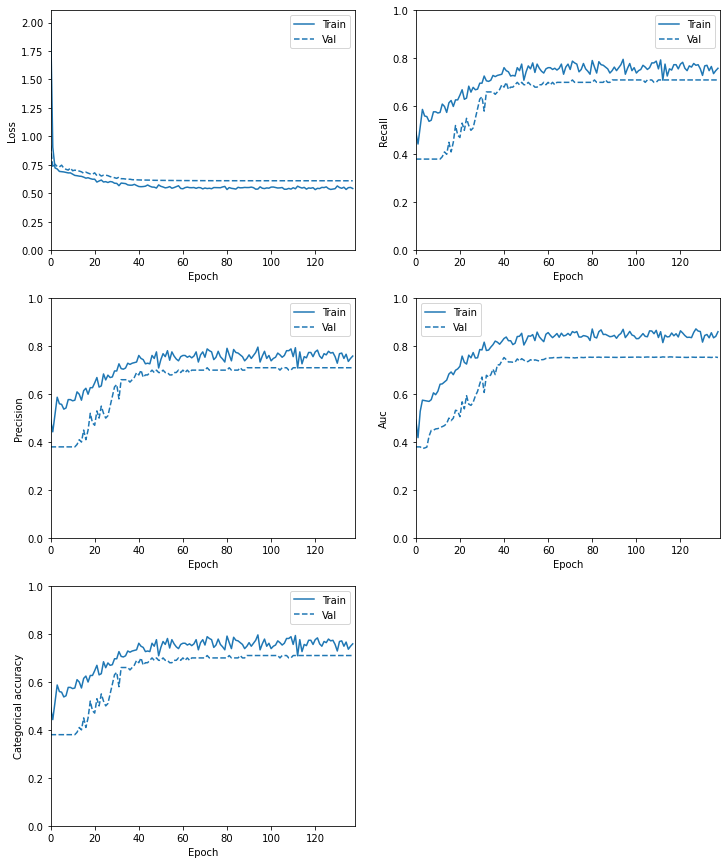

In [10]:
%%time

plot_training_history(history)

In [11]:
%%time

show_simple_metrics(model, test_seq)

loss: 0.6069678664207458
recall: 0.7099999785423279
precision: 0.7099999785423279
auc: 0.7552000284194946
categorical_accuracy: 0.7099999785423279

Wall time: 30.2 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8235294117647058
recall: 0.6774193548387096
f1-score: 0.743362831858407
support: 62


CN
precision: 0.5918367346938775
recall: 0.7631578947368421
f1-score: 0.6666666666666667
support: 38


micro avg
precision: 0.71
recall: 0.71
f1-score: 0.7100000000000001
support: 100


macro avg
precision: 0.7076830732292917
recall: 0.7202886247877759
f1-score: 0.7050147492625369
support: 100


weighted avg
precision: 0.7354861944777911
recall: 0.71
f1-score: 0.7142182890855457
support: 100


samples avg
precision: 0.71
recall: 0.71
f1-score: 0.71
support: 100


F1
micro: 0.7100000000000001
macro: 0.7050147492625369


accuracy_score: 0.71
sensitivity_score: 0.6774193548387096
specificity_score: 0.7631578947368421


Wall time: 28.1 s


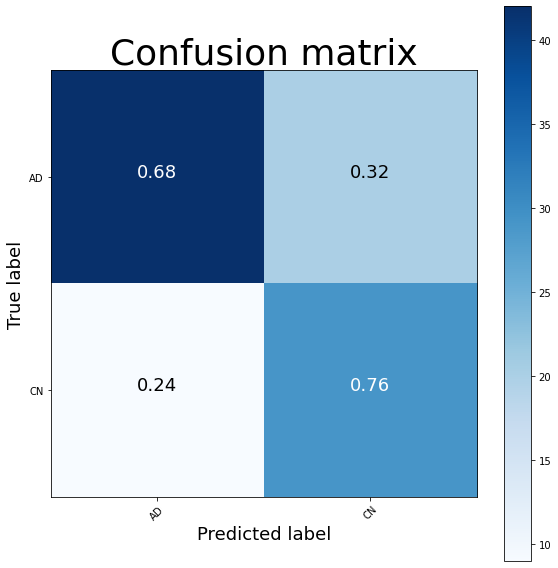

In [12]:
%%time

show_metrics(model, test_seq, class_names)